# CDS 303 Group 3 Project: Phishing and Spam Categorization Code
### Outline of Code
- Importing the Cleaned Data With Unique Features
- Logistic Regression
- Exploration of Alternative Models
- Importing Tokenized and Vectorized Emails
- Apply the same models

## Importing the Cleaned Data

In [4]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn import datasets, model_selection, metrics
from sklearn import linear_model, naive_bayes, tree
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Importing Data
df = pd.read_csv("../CDS303/CSV Files/Post_EDA_encoded_df.csv")
df.head()

from sklearn.preprocessing import StandardScaler

# Scale the data
y = df['Safe_Email']
X = df.drop(['Safe_Email'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Splitting the Data, Training versus Testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.3)

X_train_pct = round((len(X_train) / (len(X_train) + len(X_test))), 2)
X_test_pct = round((len(X_test) / (len(X_train) + len(X_test))), 2)

print('Classification training dataset shape is:', X_train.shape, 'Testing dataset shape is:', X_test.shape)
print('Regression train/test split is:', X_train_pct, '/', X_test_pct)

Classification training dataset shape is: (12670, 19) Testing dataset shape is: (5431, 19)
Regression train/test split is: 0.7 / 0.3


## Logistic Regression
### Creation and Tuning

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
# Define your logistic regression model
logistic_model = linear_model.LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

# Stratified K-Fold cross-validation
from sklearn.model_selection import StratifiedKFold
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation metrics for each fold
fold_results = []

for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    
    # Train the model on the training fold
    logistic_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation fold
    y_pred_fold = logistic_model.predict(X_val_fold)
    
    # Evaluate the model on the validation fold
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    precision = precision_score(y_val_fold, y_pred_fold)
    recall = recall_score(y_val_fold, y_pred_fold)
    f1 = f1_score(y_val_fold, y_pred_fold)
    
    # Store the results for this fold
    fold_results.append({'Fold': fold_idx,
                         'Accuracy': accuracy,
                         'Precision': precision,
                         'Recall': recall,
                         'F1 Score': f1})

# Create a DataFrame to store the fold-wise results
results_df = pd.DataFrame(fold_results)

# Calculate mean scores across all folds
mean_scores = results_df.mean(axis=0)

# Create a DataFrame for mean scores
mean_scores_df = pd.DataFrame(mean_scores).transpose()

# Set the 'Fold' column to 'Mean' for the mean scores DataFrame
mean_scores_df['Fold'] = 'Mean'

# Concatenate the mean scores DataFrame with the original results DataFrame
results_df = pd.concat([results_df, mean_scores_df], ignore_index=True)

# Display the results DataFrame
results_df

,Fold,Accuracy,Precision,Recall,F1 Score
0,1,0.750197,0.727767,0.947267,0.823135
1,2,0.749408,0.727048,0.947267,0.822675
2,3,0.762036,0.736921,0.951737,0.830666
3,4,0.732044,0.716477,0.931789,0.810070
4,5,0.754538,0.730237,0.951094,0.826160
5,Mean,0.749645,0.727690,0.945831,0.822541


We fit the model, but we have unbalanced classes. Because there are approximately 11,000 safe emails versus 7,000 unsafe emails, we use stratified k-fold cross validation.

The model has a mean accuracy of .75 across all 5 of the folds. This is the overall correctness of the model. It is measured by taking the overall correct predictions divided by the total number of cases examined. Precision refers to the accuracy of the positive predictions. Recall is important when the cost of a false negative is high because it is a measure of the actual positives identified by the model. Finally, the F-Score capture the precision and recall in one number.

- Accuracy= TP+TN+FP+FN / TP+TN

- Precision= TP / TP+FP

- Recall= TP / TP+FN

- F1 Score= 2 x (Precision x Recall) / (Precision + Recall)

This Accuracy score seems quite low for the use case. We would like to predict the type of emails at least 95% of the time. The following section we explore the hyperparameter space for Logarithmic Regression.

#### Hyperparameter Search
There are 5 different hyperparameters for the logistic regression model. We perform a grid search to find the best hyperparameter. We will use the F1 score as our primary consideration for comparing the models with different hyperparameters because we have imbalanced classes and want to account for both the perfomance of the model on precision and recall.

One significant Hyperparameter is the C (Inverse Regularization Strength). This is used to prevent overfitting. A high value of C means there is less regularization and the risk of overfitting. A low vaule means there is a risk of underfitting.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import FitFailedWarning

# Ignore FitFailedWarning, because some of the combinations of hyperparameters are expected to not converge
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FitFailedWarning)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence

# Grid of parameters to search over
param_grid = [
    {'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2', 'none'], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': np.linspace(0, 1, 10)}
]

# GridSearchCV to find the best parameters, score on f1 to balance the consideration of performance on recall and precision
clf = GridSearchCV(model, param_grid, cv=5, scoring='f1')
clf.fit(X_train, y_train)

# Output the best parameters and best score
print("Best parameters:", clf.best_params_)
print("Best cross-validation score: {:.2f}".format(clf.best_score_))


Output:
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.83
These hyperparameters are added to the original code for logarithmic regression.

### Testing and Interpretation of Results

Here we define a function to create a correlation matrix. The benefit of using a function is that we can use it to compare to other modeling approaches, which we will in the next section.

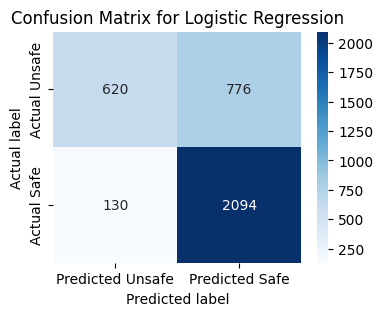

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_for_model(model, X_train, X_test, y_train, y_test, model_name, ax=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    if ax is None:
        plt.figure(figsize=(4, 3))
        ax = plt.gca()
    
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                xticklabels=['Predicted Unsafe', 'Predicted Safe'], 
                yticklabels=['Actual Unsafe', 'Actual Safe'], ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')

plot_confusion_matrix_for_model(logistic_model, X_train, X_test, y_train, y_test, "Logistic Regression")


The results are somewhat of a summary of the same information encapsulated in the Accuracy Score and F Score. We can see that the model is more likely to accidently predict something as safe when it is actually unsafe when compared to accidently predicting something as unsafe when it is safe. Or p(FP) > p(FN)

## Comparison to Other Models
The following code runs through several alternative models including: K Nearest Neighbors, Support Vector Machine, Decision Tree Classifier, Random Forest Classifier, and Multi Layer Perceptron Classifier.

- *K Nearest Neighbor* or KNN categorize points by the category of whichever group has the most points near it given some number of nearest points. This is considered a "lazy learner."
- *Support Vector Machine* can be used for classification or regression. It searches for a "hyperplane" that best seperates the classes in a high-dimensional space.
- *Decision Tree Clssifier* constructs decision trees dividing data based on the feature that will give the largest information gain on each level of analysis.
- *Random Forest Classifier* outputs the mean prediction of a forest of decision trees from training.
- *Multi Layer Perceptron Classifier* is an artificial neural network where every node is fully connected to the nodes in adjacent layers.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import pandas as pd

param_dict = {
    'knn': ('n_neighbors', [2, 3, 4, 5, 6, 7, 8], 'weights', ['uniform', 'distance']),
    'svc': ('C', [1, 2], 'kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'dt': ('criterion', ['gini', 'entropy', 'log_loss'], 'max_depth', [2, 3, 4, 5, 6]),
    'rf': ('n_estimators', [50, 100, 150, 200], 'max_depth', [2, 3, 4, 5, 6]),
    'mlp': ('activation', ['identity', 'logistic', 'tanh', 'relu'], 'solver', ['lbfgs', 'sgd', 'adam'])
}

model_dict = {
    'knn': KNeighborsClassifier(),
    'svc': SVC(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(),
    'mlp': MLPClassifier(),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

summary = []
cm_df = pd.DataFrame()

for i in ['knn', 'svc', 'dt', 'rf', 'mlp']:
    param_grid = list(itertools.product(param_dict[i][1], param_dict[i][3]))
    for k in range(len(param_grid)):
        param_grid_dict = {param_dict[i][0]: param_grid[k][0], param_dict[i][2]: param_grid[k][1]}
        model = model_dict[i]
        
        for train_index, test_index in skf.split(X_scaled, y):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.set_params(**param_grid_dict)
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            summary.append([i, param_dict[i][0], param_grid[k][0], param_dict[i][2], param_grid[k][1],
                            accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'),
                            recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')])
            
            dfpred = pd.DataFrame([y_pred]).transpose()
            dftest = pd.DataFrame([y_test]).transpose()
            cm_data_temp = pd.concat([dfpred, dftest], axis=1)
            cm_df = pd.concat([cm_df, cm_data_temp], axis=0)

summary_df = pd.DataFrame(summary, columns=('model', 'param1', 'parval1', 'param2', 'parval2', 'accuracy', 'precision', 'recall', 'f1'))
best_df = summary_df.nlargest(15, 'f1')
cm_df.columns = ('ypred', 'ytest')

best_df

,model,param1,parval1,param2,parval2,accuracy,precision,recall,f1
45,knn,n_neighbors,6,weights,distance,0.848937,0.843065,0.835577,0.838896
331,mlp,activation,relu,solver,lbfgs,0.848895,0.845329,0.832288,0.837643
341,mlp,activation,relu,solver,adam,0.849171,0.846489,0.831577,0.837556
334,mlp,activation,relu,solver,lbfgs,0.846961,0.840130,0.834912,0.837303
316,mlp,activation,tanh,solver,lbfgs,0.848343,0.845057,0.831304,0.836896
46,knn,n_neighbors,6,weights,distance,0.846961,0.840869,0.833523,0.836783
55,knn,n_neighbors,7,weights,distance,0.847004,0.841365,0.832936,0.836617
68,knn,n_neighbors,8,weights,distance,0.846961,0.841749,0.832186,0.836296
343,mlp,activation,relu,solver,adam,0.848343,0.847002,0.829164,0.836056
35,knn,n_neighbors,5,weights,distance,0.845899,0.839426,0.832971,0.835872


The best results across these models are comparable to the Logistic Regression result.
Below are the correlation matrices for the 2 best models: mlp, knn.

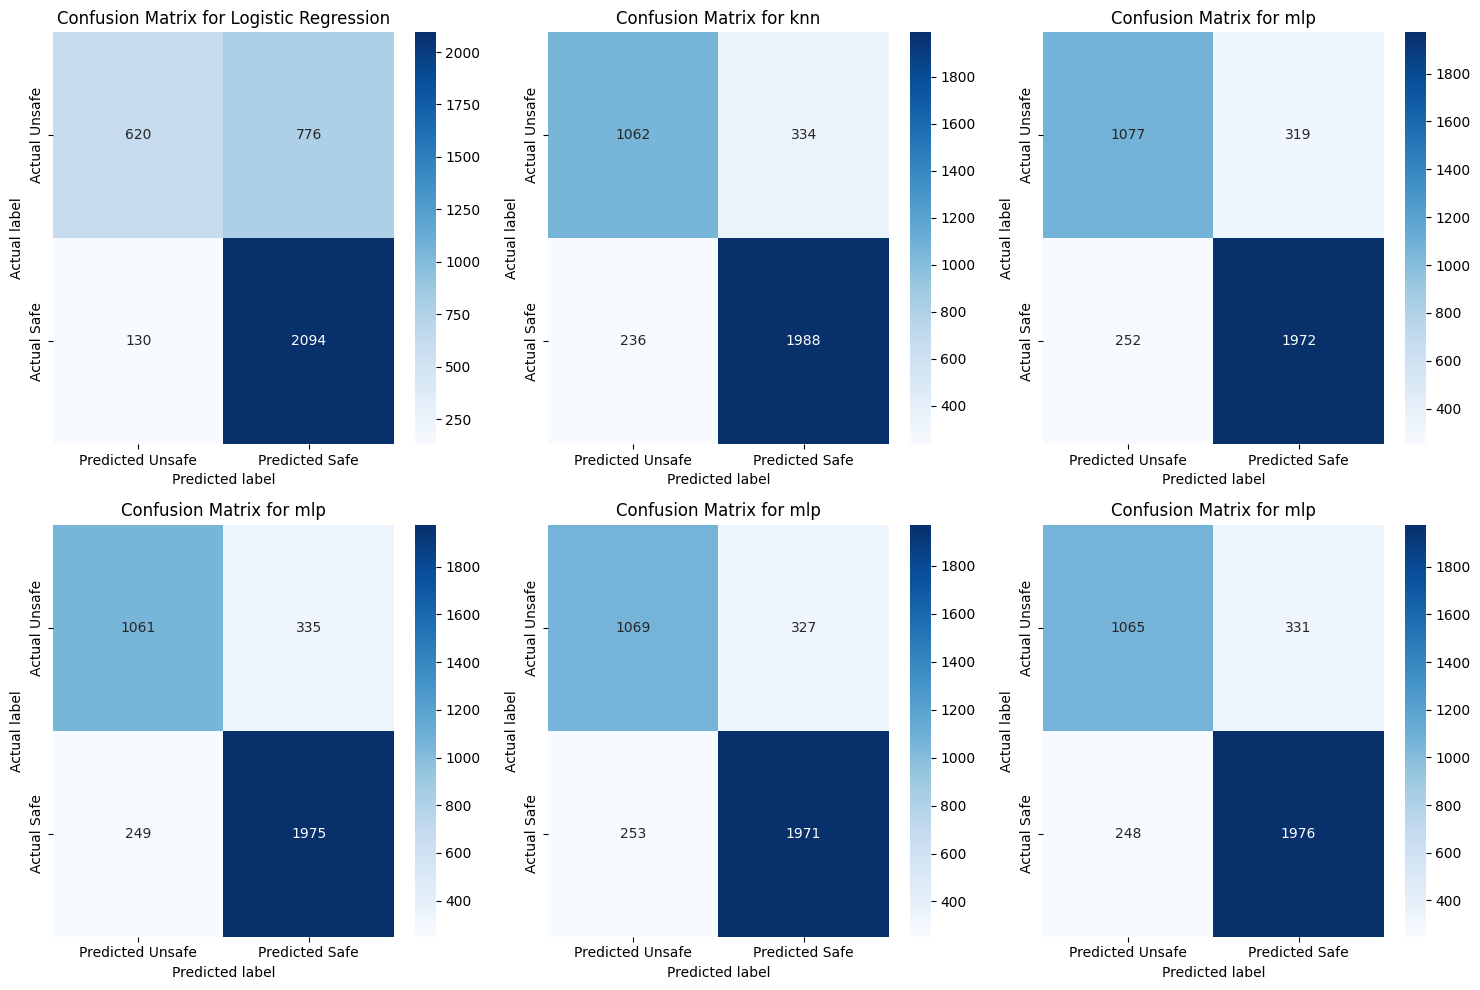

In [21]:
# Sort best_df by F1 score in descending order and select the top 5 models
top_5_models_df = best_df.nlargest(5, 'f1')

# Extract Hyperparameters for Top 5 Models
best_hyperparameters_top_5 = top_5_models_df[['model', 'param1', 'parval1', 'param2', 'parval2']].values

# Reinitialize Models with Hyperparameters
models_with_hyperparameters_top_5 = {}
for row in best_hyperparameters_top_5:
    model_name, param1, parval1, param2, parval2 = row
    if model_name in model_dict:
        model = model_dict[model_name]
        model.set_params(**{param1: parval1, param2: parval2})
        if model_name not in models_with_hyperparameters_top_5:
            models_with_hyperparameters_top_5[model_name] = []
        models_with_hyperparameters_top_5[model_name].append(model)

# Fit Models with Training Data
trained_models_top_5 = {}
for model_name, models_list in models_with_hyperparameters_top_5.items():
    trained_models_top_5[model_name] = []
    for model in models_list:
        clf = model.fit(X_train, y_train)
        trained_models_top_5[model_name].append(clf)


# Plotting all confusion matrices in a grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot Logistic Regression Confusion Matrix
plot_confusion_matrix_for_model(logistic_model, X_train, X_test, y_train, y_test, "Logistic Regression", ax=axs[0, 0])
axs[0, 0].set_title("Confusion Matrix for Logistic Regression")

# Plotting other confusion matrices
row = 0
col = 1
for model_name, model_list in trained_models_top_5.items():
    for model in model_list:
        plot_confusion_matrix_for_model(model, X_train, X_test, y_train, y_test, model_name, ax=axs[row, col])
        axs[row, col].set_title(f"Confusion Matrix for {model_name}")
        col += 1
        if col == 3:
            col = 0
            row += 1

plt.tight_layout()
plt.show()


The results make clear that the mlp models outperform the logistic regression approach by having fewer unsafe emails predicted as safe.

## Logistic Regression on Email Text Data
### The Process

### Training

### Results